In [1]:
"""Visualizes Releases and Restatements

Visualize the effects of a change in data production
on releases
"""


'Visualizes Releases and Restatements\n\nVisualize the effects of a change in data production\non releases\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from copy import copy, deepcopy
import numpy as np
from collections import defaultdict
from math import floor, ceil
import random
from types import SimpleNamespace
import plotly.graph_objects as go
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mplc
import matplotlib.ticker as mtk
import pathlib
from scipy import stats
from sklearn.cluster import AgglomerativeClustering

In [3]:
random.seed(217)
path = '../latex/plots/simulations/'

plus_color = "mediumseagreen"
minus_color = "mediumvioletred"

In [4]:
def map_colors(release_df, observations=True, releases=True):
    observation_dates, release_dates = [], []
    if observations:
        observation_dates = [o for o in release_df.index]
    if releases:
        release_dates = [r for r in release_df.columns]
    dates = sorted(list(set(observation_dates + release_dates)))
    
    n = len(dates)
    min_val, mid_val1, mid_val2, max_val = 0,.15, 0.35,1.0
    k = (n // 5)
    orig_cmap = plt.cm.gist_rainbow
    colors1 = orig_cmap(np.linspace(min_val, mid_val1, k))
    colors2 = orig_cmap(np.linspace(mid_val2, max_val, n-k))
    colors = np.concatenate((colors1, colors2))
    
    return {day: color for day, color in zip(dates, colors) }

In [5]:
def add_plot_shift(release_df, shift=.05):
    
    df = pd.DataFrame()
    
    for i, col_info in enumerate(release_df.iteritems()):
        name, vals = col_info
        df[name] = vals + (i * shift)
    
    return df

In [6]:
def square_releases(release_df):
    """creates dataframe with diagonal of index date, date+1"""
    observation_dates = [o for o in release_df.index]
    release_dates = [r for r in release_df.columns]
    vals = sorted(list(set(observation_dates + release_dates)))
    dates = pd.date_range(start=min(vals), end=max(vals))

    df = pd.DataFrame(columns=dates[1:], index=dates[:-1])
    df.update(release_df)

    return df

In [7]:
def get_ticks(vals):
    
    num = len(vals)
    
    if num <=10:
        return [val for val in vals]
    
    if num / 2 <= 10:
        m = num // 2
        ticks = sorted(list(set([vals[i*2] for i in range(m)] + [vals[-1]])))
        return ticks

    den = 5

    while True:
        if num / den <= 10:
            m = num // den
            ticks = sorted(list(set([vals[i*den] for i in range(m)] + [vals[-1]])))
            return ticks
        else:
            den += 5

In [8]:
def within_release_shifts(
    releases_df, alpha=2, window=14, func="avg",
    negative=True, positive=True, percent = True, limit=None,
    **kwargs
):
    """
    Calculates and filters the changes between subsequent values within a release
    Returns a dataframe with all null values except those meeting below criteria
    
    If percent == True, 
        value = change / func(sequential changes over the previous window size)
    Else:
        value = change
        
    Returns values for only those positions that are greater than alpha
        if negative == False and positive == True, then only values greater than alpha returned nonnull
        if negative == True and positive == False, then only less than negative -abs(alpha) returned monnull
        else: abs(value) > alpha returned nonnull
        
    If limit is set to an integer, 
        only the top limit of values that exceed alpha will be returned 
        
    Default func is a simple average of the absolute values
        
    Example of alternate funcs:
        lambda x: max(abs(x))
        exponential mean
        weighted mean
    """
    
    if func == "avg":
        def avg_func(vals):
            return sum(abs(vals))/len(vals)
        
        func = avg_func
    
    output = defaultdict(dict)
    df = deepcopy(releases_df)
    
    for release, vals in df.ffill(axis='columns').iteritems():
        diffs = vals.diff()               
        
        for ind in range(window, len(vals)):
            
            start = ind - window
            obsv = vals.index[ind]
            prev = diffs[start:ind]
            cur = diffs[ind]
            
            if percent:
                statistic = func(prev)

                if statistic != 0:

                    perc = (cur / statistic) - 1

                else:
                    perc = np.sign(cur)*np.inf

                output[release][obsv] = perc
                
            else:
                output[release][obsv] =  cur

           
    df = pd.DataFrame(output)
    
    if isinstance(limit, int):

        vals = df.to_numpy()
        vals = vals[~np.isnan(vals)].flatten()

        if negative and positive:
            vals = list(set(abs(vals)))
            cutoff = max(alpha, sorted(vals)[-limit])

        elif positive:
            vals = list(set(vals))
            cutoff = max(alpha, sorted(vals)[-limit])
        
        elif negative:
            vals = list(set(vals))
            cutoff = min(-abs(alpha), sorted(vals)[limit])

    else:
        cutoff = alpha
    
    if negative and positive:
        return df[abs(df) > cutoff]
    
    elif negative:
        return df[df < -abs(cutoff)]
        
    elif positive:
        return df[df > cutoff]
    
    else:
        raise ValueError
        print("At least one of negative and positive must be True\Defaulting to both True")
        return df[abs(df) > alpha]

In [9]:
def major_restatements(release_df, min_perc_changed):
    
    restatements, restatement_pairs = [], []
    first_reported = {}
    first_reported_date = {}
    first_expected_reported = {}
    first_expected_reported_date = {}
    last_reported = {}
    last_reported_date = {}
    restatements_details = {}
    
    diffs = release_df.ffill(axis='columns').diff(axis=1)
    
    for obsv, row in release_df.iterrows():
        
        vals = row.dropna()
        
        if len(vals) >0:
            first_reported[obsv] = vals.iloc[0]
            first_reported_date[obsv] = vals.index[0]
            last_reported[obsv] = vals.iloc[-1]
            last_reported_date[obsv] = vals.index[-1]
            
        else:
            first_reported[obsv] = None
            last_reported[obsv] = None    
            
        try:
            exp_vals = row[obsv:][1:].dropna()
            first_expected_reported[obsv] = exp_vals[0]
            first_expected_reported_date[obsv] = exp_vals.index[0]
        
        except (KeyError, IndexError):
            pass
    
    last_release = None
    
    for release, r_diffs in diffs.iteritems():      
        
        vals = r_diffs.dropna()
        nonzero = [v for v in vals if v != 0]
        
        if len(vals) > 0 and len(nonzero) / len(vals) > min_perc_changed:
            
            restatements.append(release)
            restatement_pairs.append((last_release, release))
            restatements_details[release] = {
                "mean": np.mean(vals),
                "stdev":np.std(vals) ,
                "median": np.median(vals),
                "number": len(nonzero),
                "percent_changed": len(nonzero) / len(vals)
                
            }

        last_release = release
            
    return {
        "restatements": restatements,
        "first_reported": pd.Series(first_reported),
        "first_reported_date": pd.Series(first_reported_date),
        "last_reported": pd.Series(last_reported),
        "last_reported_date": pd.Series(last_reported_date),
        "first_expected_reported": pd.Series(first_expected_reported),
        "first_expected_reported_date": pd.Series(first_expected_reported_date),
        "restatement_pairs": restatement_pairs,
        "restatements_details": restatements_details
    }
            

In [10]:
def setup_plot(
    release_df, title, data_title, x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(10,7), sharex=True, sharey=True, **kwargs
):

    # standards
    plt.style.use('../Style/plot.mplstyle')
    
    # setup axis    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey, squeeze=False)
    
    ax = axs[nrows-1, 0]
    
    if nrows*ncols == 1:
        axs = axs[0,0]
#         plt.suptitle(title + " " + data_title, fontsize=20)
        plt.title(title + ": " + data_title,  fontsize=23)

    else:
        fig.suptitle(title + " : " + data_title, fontsize=23)
    
    if len(x_label) > 25:
        ax.set_xlabel(x_label, fontsize=16)
    else:
        ax.set_xlabel(x_label)
    
    if len(y_label) > 25:
        ax.set_ylabel(y_label, fontsize=16)
    else:
        ax.set_ylabel(y_label)

    plt.xticks(rotation = 90)
    
    setup_dct = deepcopy(kwargs)
    setup_dct["title"] = title
    setup_dct["data_title"] = data_title
    setup_dct["x_label"] = x_label
    setup_dct["y_label"] = y_label
    setup_dct["y_scale"] = y_scale
    setup_dct["file_name"] =  data_title.replace(" ", "_") + "__" + title.replace(" ", "_")
    setup_dct["observation_dates"] = release_df.index
    setup_dct["release_dates"] = release_df.columns

    return plt, axs, setup_dct


In [11]:
def show_or_save(func):
    
    def inner(release_df, data_title, save=False, **kwargs):
#         plt.clf()
#         plt.close('all')
        
        fig, ax, plot_dct = func(release_df, data_title, **kwargs)
        plt.tight_layout()
                
        if save:
            plt.savefig(pathlib.Path(path, plot_dct["file_name"]), bbox_inches="tight")
        else:
            plt.show()

        return fig, ax, plot_dct
    
    return inner

In [12]:
@show_or_save
def plot_multiple_releases(
    release_df,
    data_title,
    shift="default",
    alpha=.9,
    **kwargs
):
    """
    Plot multiple releases via shifted line plot
    
    if shift = "default", shift will equal (max - min / 100)
    """
    
    standard_dct = deepcopy(kwargs)
    standard_dct["title"] = 'Reported Values by Release'
    standard_dct["x_label"] = 'Observation Date'
    standard_dct["y_label"] = 'Counts'
    
    standard_dct['data_title'] = data_title
    
    plt, ax, plt_dct = setup_plot(release_df, **standard_dct)
    
    ns = SimpleNamespace(**plt_dct)
    
    # colors
    colors = map_colors(release_df, observations=False)
    
    # make data    
    max_val = release_df.replace([np.inf, -np.inf], np.nan).max().max() * 1.2
    min_val = release_df.replace([np.inf, -np.inf], np.nan).min().min()
    if shift == "default":
        shift = (max_val - min_val )/ 100
    release_df_shifted = add_plot_shift(release_df, shift)
    max_y_limit = release_df_shifted.replace([np.inf, -np.inf], np.nan).max().max()
    
    # plot_data
    i = 0
    j = 0
    label_mod = max(1, len(release_df_shifted.columns) // 10)
    for release_date, vals in release_df_shifted.iteritems():
        
        nonnull = vals.dropna()
        if len(nonnull) > 0:
            last_obsv = vals.dropna().index[-1]
            last_val = vals.dropna().iloc[-1]
            ax.plot(vals, '-', color=colors[release_date], linewidth=1, label=release_date, alpha=alpha)

            if i % label_mod == 0:
                plt.gcf().text(
                    1, .2 + .03*j,
                    release_date.strftime('%Y-%m-%d'),
                    color=colors[release_date],
                    fontsize=12
                )
                j += 1
            i+=1

    ax.get_yaxis().set_major_formatter(mtk.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.xticks(rotation=30, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %y'))
    # add legend
    plt.gcf().text(1, .2 + .03*j, f'{i} releases\nplotted',
        color='black', fontsize=12)
    
    return plt.gcf(), ax, plt_dct

In [13]:
@show_or_save
def plot_staircase(
    release_df,
    data_title,
    heatmap=False,
    missing=True,
    high_val_key="additive correction",
    low_val_key="subtractive correction",
    **kwargs
):
    
    standard_dct = deepcopy(kwargs)
    
    if "title" not in standard_dct:
        if heatmap:
            standard_dct["title"] = 'Heatmap'
        else:
            standard_dct["title"] = 'Between Release Changes'

    standard_dct["x_label"] = 'Release Date'
    standard_dct["y_label"] = 'Observation Date'
    
    standard_dct['data_title'] = data_title
    
    # get all expected releases
    square_df = square_releases(release_df)
    plt, ax, plt_dct = setup_plot(square_df, **standard_dct)
    
    # still need?
    ns = SimpleNamespace(**plt_dct)
    
    x_index_dct = {release : ind for ind, release in enumerate(square_df.columns)}
    y_index_dct = {obsv : ind for ind, obsv in enumerate(square_df.index)}
    
    # specify axis
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
        
    x_ticks_labels = get_ticks(ns.release_dates)
    x_ticks_locations = [x_index_dct[r] for r in x_ticks_labels]
    x_ticks_str = [d.strftime('%Y-%m-%d') for d in x_ticks_labels]
    ax.set_xticks(x_ticks_locations)
    ax.set_xticklabels(x_ticks_str)
    plt.xticks(rotation=30)    

    y_ticks_labels = get_ticks(ns.observation_dates)
    y_ticks_locations = [y_index_dct[o] for o in y_ticks_labels]
    y_ticks_str = [d.strftime('%Y-%m-%d') for d in y_ticks_labels]
    ax.set_yticks(y_ticks_locations)
    ax.set_yticklabels(y_ticks_str)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.invert_yaxis()

    # draw staircase
    ## runs (releases)
    rs = [(ind, ind) for ind, release in enumerate(square_df.columns)]
    rs = [each for pair in rs for each in pair]
    rs = rs[:-1]
    ## rises (observations)
    os = [(ind, ind) for ind, obs in enumerate(square_df.index)]
    os = [each for pair in os for each in pair]
    os = os[1:]
    minlen = min(len(os), len(rs))
    ## plot the staircase
    ax.plot(rs, os, color="grey")
    
    max_val = int(release_df.replace([np.inf, -np.inf], np.nan).max().max())
    min_val = int(release_df.replace([np.inf, -np.inf], np.nan).min().min())

    
    if not heatmap:
        # make data

#         ## changes between releases
#         release_diffs = square_df.ffill(axis='columns').diff(axis=1)
        max_diff = ceil(square_df.replace([np.inf, -np.inf], np.nan).max().max())
        min_diff = floor(square_df.replace([np.inf, -np.inf], np.nan).min().min())

        ### make colors
        if min_diff < 0:
            reds = plt.cm.Reds_r(np.linspace(0, 1, abs(min_diff) + 1))
            reds_dct = {min_diff + i: c for i,c in enumerate(reds)}

        if max_diff > 0:
            greens = plt.cm.Greens(np.linspace(0, 1, max_diff + 1))
            greens_dct = {i: c for i,c in enumerate(greens)}

        ### map changes to colors
        for release_date, vals in square_df.iteritems():
            nonnull = vals.dropna()

            for obsv_date, d in nonnull.items():

                if d > 0:
                    ax.add_patch(
                        Rectangle(
                            (x_index_dct[release_date], y_index_dct[obsv_date])
                            , 1, 1, facecolor=greens_dct[min(max_diff, int(d))], edgecolor='green')
                    )

                if d < 0:
                    ax.add_patch(
                        Rectangle(
                            (x_index_dct[release_date], y_index_dct[obsv_date])
                            , 1, 1, facecolor=reds_dct[max(min_diff, int(d))], edgecolor='red')
                    )

        # legend can remain inside the plot, as lower left corner will always be empty
        if max_diff > 0:
            ax.text(0.05, 0.07,high_val_key,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes,
                color="green", fontsize=12)

        if min_diff < 0:
            ax.text(0.05, 0.04, low_val_key,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes,
                color="red", fontsize=12)

    # heatmap
    if heatmap:
#         max_val = int(release_df.replace([np.inf, -np.inf], np.nan).max().max())
#         min_val = int(release_df.replace([np.inf, -np.inf], np.nan).min().min())
        colors = plt.cm.RdYlBu_r(np.linspace(0, 1, max_val - min_val + 1))

        for release_date, vals in square_df.iteritems():
            reported = vals.dropna()

            for obsv_date, m in reported.items():
                
                ax.add_patch(
                    Rectangle(
                        (x_index_dct[release_date], y_index_dct[obsv_date])
                        , 1, 1, color=colors[int(max(0, min(max_val, m) - min_val))]
                    )
                )
        
        # legend can remain inside the plot, as lower left corner will always be empty
        ax.text(0.05, 0.07, 'high',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color=colors[-1], fontsize=12)
        ax.text(0.05, 0.04, 'low',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color=colors[0], fontsize=12)

    ## missing data
    if missing:
        for release_date, vals in square_df.iteritems():
            expected = vals[:release_date][:-1]
            missing = expected.isna()

            for obsv_date, m in missing.items():
                if m:
                    ax.add_patch(
                        Rectangle(
                            (x_index_dct[release_date], y_index_dct[obsv_date])
                            , 1, 1,color="black")
                    )

        # missing legend
        ax.text(0.05, 0.01, 'missing',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='black', fontsize=12)
    
    return plt.gcf(), ax, plt_dct
    

In [14]:
def plot_within_release_changes(
    release_df,
    data_title,
    window=7,
    alpha=2,
    **kwargs
):
    
    changes_df = within_release_shifts(release_df, window=window, alpha=alpha, **kwargs)
    
    dct = deepcopy(kwargs)
    dct["missing"] = False
    dct["heatmap"] = False
    dct["title"] = "Within Release Changes"
    dct['within_release_changes'] = changes_df
    
    return plot_staircase(changes_df, data_title, **dct)

In [15]:
def plot_between_release_changes(
    release_df,
    data_title,
    window=7,
    alpha=2,
    **kwargs
):
    square_df = square_releases(release_df)
    changes_df  = square_df.ffill(axis='columns').diff(axis=1)

    dct = deepcopy(kwargs)
    dct["missing"] = False
    dct["heatmap"] = False
    dct["title"] = "Between Release Changes"
    
    return plot_staircase(changes_df, data_title, **dct)


In [16]:
@show_or_save
def plot_restatement_lags(
    release_df,
    data_title,
    **kwargs
):
    
    standard_dct = deepcopy(kwargs)

    standard_dct["title"] = 'Time Till Restatement'
    standard_dct["x_label"] = 'Observation Date'
    standard_dct["y_label"] = 'Days After Observation'
    
    standard_dct['data_title'] = data_title
    
    # get all expected releases
    plt, ax, plt_dct = setup_plot(release_df, **standard_dct)
    
    # still need?
    ns = SimpleNamespace(**plt_dct)
    
    colors = map_colors(release_df)
    
    # make data
    obsvs, diffs, updates, colors, edgecolors = [], [], [], [], []
    
    release_diffs = release_df.ffill(axis='columns').diff(axis=1)
    max_diff = ceil(release_diffs.max().max())
    min_diff = floor(release_diffs.min().min())
    
    def get_size(v):
        return 10 + 150*(abs(v) / max(max_diff, abs(min_diff)))
    
    for obsv_date, vals in release_diffs.iterrows():
        
        changes = vals.dropna()
        
        for release_date, diff in changes.iteritems():
            
            if diff != 0:
                
                obsvs.append(obsv_date)
                diffs.append(get_size(diff))
                
                if isinstance(release_date, dt.datetime) and isinstance(obsv_date, dt.datetime):
                    time_diff = (release_date - obsv_date).days
                    
                elif isinstance(release_date, int) and isinstance(obsv_date, int):
                    time_diff = release_date - obsv_date
                    
                else:
                    raise TypeError('Indices and Columns must be either both datetime.datetime or int')
                
                updates.append(time_diff)
                
                if diff > 0:
                    colors.append(plus_color)
                    edgecolors.append(plus_color)
                
                else:
                    colors.append(minus_color)
                    edgecolors.append(minus_color)
            
    ax.scatter(obsvs, updates, s=diffs, facecolor=colors, edgecolor=edgecolors, alpha=.5)
    ax.set_xticks(get_ticks(ns.observation_dates))

    # these can stay inside the axis because top right will never be used
    ax.text(0.95, 0.95, 'additive correction',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color=plus_color, fontsize=12)
    ax.text(0.95, 0.92, 'subtractive correction',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color=minus_color, fontsize=12)
    ax.text(0.95, 0.89, 'size: scale of correction',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='grey', fontsize=12)

    return plt.gcf(), ax, plt_dct

In [17]:
@show_or_save
def plot_bifrost(
    release_df,
    data_title,
    percent_of="original",
    **kwargs
):
    
    standard_dct = deepcopy(kwargs)

    standard_dct["title"] = 'Adjustment Size'
    standard_dct["x_label"] = 'Observation Date'
    standard_dct["y_label"] = f'Adjustment Size as Percent of {percent_of.title()} Value'
    
    standard_dct['data_title'] = data_title
    
    # get all expected releases
    plt, ax, plt_dct = setup_plot(release_df, **standard_dct)
    
    # still need?
    ns = SimpleNamespace(**plt_dct)

    colors = map_colors(release_df)
    
    x_ticks_locations = get_ticks(ns.observation_dates)
    ax.set_xticks(x_ticks_locations)
    ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in x_ticks_locations])
    ax.spines['bottom'].set_visible(False)
    obsvs, perc_o, perc_f, updates = [], [], [], []
    
    for obsv_date, vals in release_df.iterrows():
        
        nonnulls = vals.dropna()
        
        if len(nonnulls) > 0:
            orig_val = nonnulls.iloc[0]
            final_val = nonnulls.iloc[-1]
        
            changes = vals.diff().dropna()

            for release_date, diff in changes.iteritems():

                if diff != 0:

                    obsvs.append(obsv_date)
                    
                    #  TODO: Decide how to handle 0 original or final values
                    perc_o.append(100*diff/orig_val)
                    perc_f.append(100*diff/final_val)
                    updates.append(colors[release_date])
                
    if percent_of == "original":
        ax.scatter(obsvs, perc_o, c=updates, marker='o', s=50)

    elif percent_of == "final":
        ax.scatter(obsvs, perc_f, c=updates, marker='o', s=50)
        
    else:
        raise ValueError
        print("percent_of must be in ['original', 'final']")

    
    ax.plot([ns.observation_dates[0],ns.observation_dates[-1]], [0, 0], c="white", lw=6, alpha=.5)    
    
    for release, n_release in zip(ns.observation_dates[:-1], ns.observation_dates[1:]):
        ax.plot([release, n_release], [0, 0], c=colors[release], lw=4)

    plt.yscale(ns.y_scale)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    return plt.gcf(), ax, plt_dct


In [18]:
@show_or_save
def plot_major_restatement_impacts(
    release_df,
    data_title,
    min_perc_changed = .2,
    percent=False,
    small_multiples=False,
    **kwargs
):
    
    perc_s = 'Percent '*percent
    
    standard_dct = deepcopy(kwargs)

    standard_dct["title"] = perc_s + f'Difference Between Major Restatements'
    standard_dct["x_label"] = 'Observation Date'
    standard_dct["y_label"] = perc_s + 'Change from Prior Value'
    standard_dct['data_title'] = data_title
        
    # major restatements relatie to last REPORTED value
    release_ff_df = release_df.ffill(axis='columns')
    rest_dct = major_restatements(release_ff_df, min_perc_changed)

    if small_multiples:
        nrows = len(rest_dct["restatements"])
    else:
        nrows = 1

    
    plt, axs, plt_dct = setup_plot(release_df, nrows=nrows, **standard_dct)

    ns = SimpleNamespace(**plt_dct, **rest_dct)
    colors = map_colors(release_df[ns.restatements], observations=False)

  
    x_index_dct = {d: ind for ind, d in enumerate(ns.observation_dates)}
    x_ticks_labels = get_ticks(ns.observation_dates)
    x_ticks_locations = [x_index_dct[r] for r in x_ticks_labels]
    x_ticks_str = [d.strftime('%Y-%m-%d') for d in x_ticks_labels]

    
    i = 0
    j = 0
    ax=None
    label_mod = max(1, len(ns.restatements) // 10)
    
    # % increase from previous reported value
    for prev, post in ns.restatement_pairs:

        if percent:
            changes = 100*(release_df[post] - release_df[prev])/release_df[prev]
        else:
            changes = release_df[post] - release_df[prev]
            
        changes.fillna(0,inplace=True)
        x_locations = [x_index_dct[d] for d in changes.index]


        if small_multiples:
            ax = axs[i,0]
            
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks(x_ticks_locations)
            ax.set_xticklabels(x_ticks_str)
            
            ax.fill_between(
                x_locations,
                changes, 0,
                facecolor=colors[post], lw=1, alpha=0.5,
    #             interpolate=True
            )

            ax.plot(
            [x_index_dct[d] for d in ns.observation_dates], [0 for each in ns.observation_dates],
            c="grey", lw=1)
            
            ax.text(
                        .01, .01,
                        post.strftime('%Y-%m-%d'),
                        color=colors[post],
                        fontsize=12,
                        transform=ax.transAxes
                    )
            
        else:
            ax = axs
            ax.fill_between(
                x_locations,
                changes, 0,
                facecolor=colors[post], lw=1, alpha=0.5,
    #             interpolate=True
            )

            ax.plot(
                [x_index_dct[d] for d in ns.observation_dates], [0 for each in ns.observation_dates],
                c="grey", lw=1)

        
            if i % label_mod == 0:            
                plt.gcf().text(
                        1, .2 + .03*j,
                        post.strftime('%Y-%m-%d'),
                        color=colors[post],
                        fontsize=12
                    )
                j += 1

        i+=1
    
    if not small_multiples:
        min_perc_str = min_perc_changed*100
        plt.gcf().text(
            1, .2 + .03*j,
            f'(min % restated {min_perc_str})',
            color='grey',
            fontsize=12
        )
        plt.gcf().text(
            1, .2 + .03*(j+1),
            f'major restatements',
            color='grey',
            fontsize=12
        )

    plt.yscale(ns.y_scale)
    if percent:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    return plt.gcf(), axs, plt_dct


In [19]:
@show_or_save
def plot_final_to_original(
    release_df,
    data_title,
    min_perc_changed = .2,
    net=True,
    percent=True,
    **kwargs
):
    
    perc_s = 'as Percent of Original '*percent
    net_s = 'Net '*net
    
    standard_dct = deepcopy(kwargs)

    standard_dct["title"] = net_s + perc_s + 'Difference'
    standard_dct["x_label"] = 'Observation Date'
    standard_dct["y_label"] = net_s + 'Adjustment ' + perc_s
    standard_dct['data_title'] = data_title
    
    # get all expected releases
    plt, ax, plt_dct = setup_plot(release_df, **standard_dct)
    
    rest_dct = major_restatements(release_df, min_perc_changed)
    ns = SimpleNamespace(**plt_dct, **rest_dct)

    colors = map_colors(release_df)

    x_ticks_locations = get_ticks(ns.observation_dates)
    x_ticks_str = [d.strftime('%Y-%m-%d') for d in x_ticks_locations]
    ax.set_xticks(x_ticks_locations)
    ax.set_xticklabels(x_ticks_str)

    zeroes = [0 for each in ns.observation_dates]    
    prev, post = ns.first_reported, ns.last_reported
    
    if not net:
        
        ax.fill_between(
            ns.observation_dates, post, prev,
            where=post>prev,
            facecolor=plus_color, lw=1, alpha=0.5,
        )
        ax.fill_between(
            ns.observation_dates, post, prev,
            where=post<prev,
            facecolor=minus_color, lw=1, alpha=0.5,
        )

        ax.plot(ns.observation_dates, prev, c="grey", lw=1, alpha=0.5)
        ax.plot(ns.observation_dates, post, c=colors[ns.release_dates[-1]], lw=1, alpha=0.5)
       
    else:    
        if percent:
            changes = 100*(post - prev)/prev

        else:
            changes = post - prev

        ax.fill_between(
            ns.observation_dates, changes, 0,
            where=changes>0,
            facecolor=plus_color, lw=1,
            interpolate=True
        )
        ax.fill_between(
            ns.observation_dates, changes, 0,
            where=changes<0,
            facecolor=minus_color, lw=1,
        )

        ax.plot(ns.observation_dates, zeroes, c='black', alpha=0.5, lw=1)

    
    plt.gcf().text(1, .2 , f'final > first reported',
        color=plus_color, fontsize=12)
    plt.gcf().text(1, .2 + .03, f'final < first reported',
        color=minus_color, fontsize=12)
    plt.yscale(ns.y_scale)
    
    if percent:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    return plt.gcf(), ax, plt_dct

In [20]:
def df_to_latex(df, data_title):
    df.to_latex(
        buf=f'../latex/tables/{data_title}.tex',
        na_rep='',
        caption=f'{data_title}',
        label=f'table: {data_title}'
    )

# DO NOT ADD BELOW TO SCRIPT

In [21]:
df = pd.read_csv("tester.csv", index_col=0)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.columns = pd.to_datetime(df.columns, format="%Y-%m-%d")
restatement_dct = major_restatements(df, .2)
r_df = df[restatement_dct['restatements']]


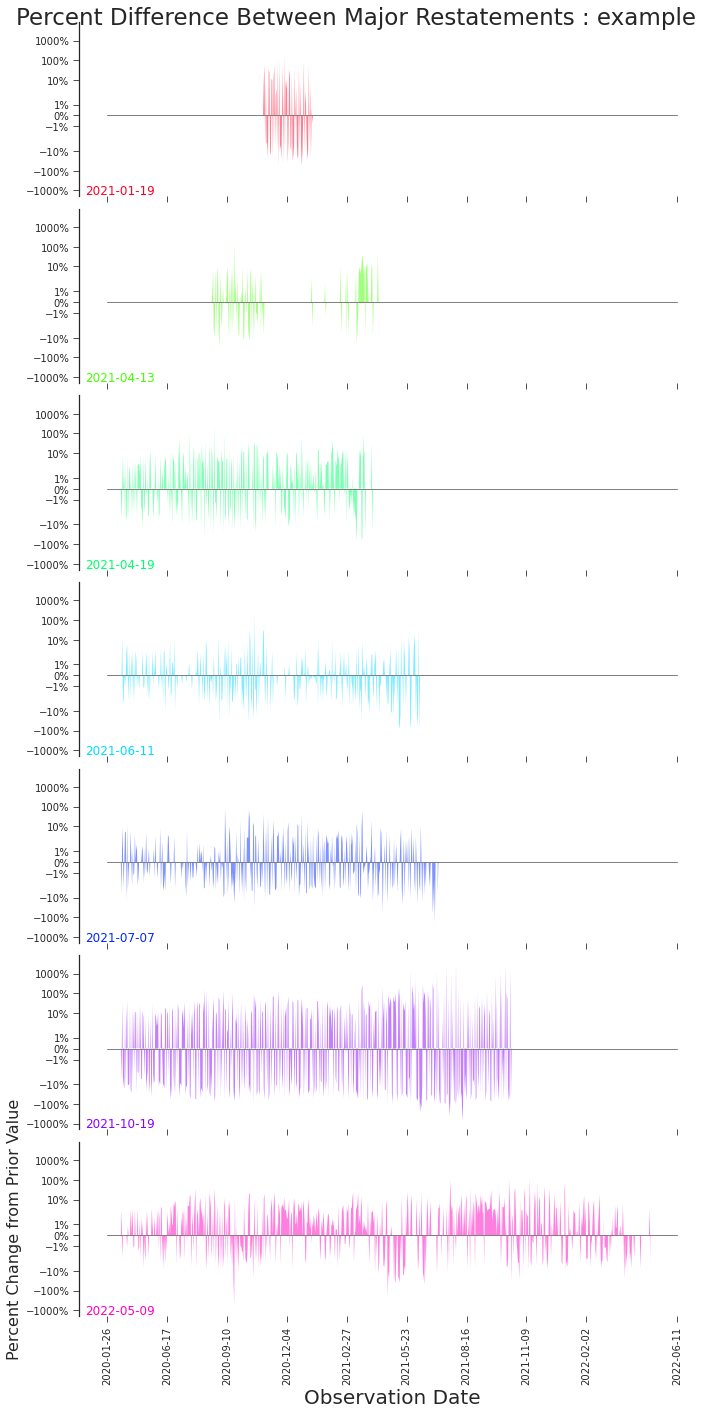

(<Figure size 720x1440 with 7 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:>],
        [<AxesSubplot:xlabel='Observation Date', ylabel='Percent Change from Prior Value'>]],
       dtype=object),
 {'missing': True,
  'title': 'Percent Difference Between Major Restatements',
  'data_title': 'example',
  'x_label': 'Observation Date',
  'y_label': 'Percent Change from Prior Value',
  'y_scale': 'symlog',
  'file_name': 'example__Percent_Difference_Between_Major_Restatements',
  'observation_dates': DatetimeIndex(['2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
                 '2020-01-30', '2020-01-31', '2020-03-10', '2020-03-11',
                 '2020-03-12', '2020-03-13',
                 ...
                 '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
                 '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
                 '2022-06-10'

In [22]:
# plot_final_to_original(r_df, "example", save=False, percent=True, net=True)
plot_major_restatement_impacts(
    df.diff(), "example", save=False, missing=True, small_multiples=True, percent=True,
    figsize=(10, 20), y_scale="symlog")
# plot_between_release_changes(df, "example", save=False, missing=True)
# plot_within_release_changes(df, "example", save=False, alpha=0, window=1, positive=False, func=lambda x: 1)
# plot_within_release_changes(df, "example", save=False)

In [23]:
from jupyckage.jupyckage import notebook_to_package
import shutil

to_latex_folder = "../latex/code/notebooks/"

notebook_name = "VisualizingRestatements"

notebook_to_package(f'{notebook_name}.ipynb')

shutil.copy( f'notebooks/src/{notebook_name}/{notebook_name}.py', f'{to_latex_folder}{notebook_name}.py')

'../latex/code/notebooks/VisualizingRestatements.py'